<a href="https://colab.research.google.com/github/riddhi-speaks/Rotate-Object-in-Image/blob/main/Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install necessary libraries
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu118
!pip install ultralytics transformers diffusers opencv-python pillow
!pip install git+https://github.com/facebookresearch/segment-anything.git
!pip install matplotlib


Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu118
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-63nj5_y9
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-63nj5_y9
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done


In [ ]:
import os
import cv2
import torch
import numpy as np
from ultralytics import YOLO
from transformers import pipeline
from segment_anything import SamPredictor, sam_model_registry
import matplotlib.pyplot as plt
from PIL import Image
from google.colab import files


In [ ]:

# Step 3: Define cosine similarity function
def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

# Step 4: Find the most similar class
def find_most_similar_class(detected_classes, target_class, similarity_model):
    target_vector = np.mean(similarity_model(target_class), axis=1)
    max_similarity = -1
    best_class = None

    for detected_class in detected_classes:
        detected_vector = np.mean(similarity_model(detected_class), axis=1)
        similarity = cosine_similarity(target_vector[0], detected_vector[0])

        if similarity > max_similarity:
            max_similarity = similarity
            best_class = detected_class

    return best_class




In [ ]:
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth # Download the checkpoint file


--2024-10-04 15:42:35--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.244.202.103, 18.244.202.73, 18.244.202.62, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.244.202.103|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth.2’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G   167MB/s    in 21s     

2024-10-04 15:42:57 (114 MB/s) - ‘sam_vit_h_4b8939.pth.2’ saved [2564550879/2564550879]



In [ ]:
def segment_object(image_path, class_name, output_path):
    # Load the image
    image = cv2.imread(image_path)
    original_height, original_width = image.shape[:2]  # Store original image dimensions

    # Load the SAM model
    sam_checkpoint = "sam_vit_h_4b8939.pth"  # Ensure this checkpoint is available
    model_type = "vit_h"
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Initialize SAM model
    sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
    sam.to(device=device)
    predictor = SamPredictor(sam)

    # Use a pre-trained language model for semantic similarity (e.g., BERT)
    similarity_model = pipeline("feature-extraction", model="bert-base-uncased", tokenizer="bert-base-uncased", device=0 if device == 'cuda' else -1)

    # Resize the image to 1024x1024 for SAM input (as per model expectation)
    image_resized = cv2.resize(image, (1024, 1024))
    predictor.set_image(image_resized)

    # Input point and label manually defined
    input_point = np.array([[512, 512]])  # Example input point near object center
    input_label = np.array([1])  # Label (1 indicates object is present at input point)

    # Perform segmentation with SAM
    masks, scores, logits = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=False,  # We'll use only one mask
    )

    # Placeholder class for the detected object
    detected_classes = ["object"]

    # Find the most similar detected class to the user-provided class
    best_class = find_most_similar_class(detected_classes, class_name, similarity_model)

    if best_class:
        # Apply red mask where the object is detected
        mask = masks[0]  # Get the first mask since multimask_output is False

        # Resize the mask to match the original image size using proper scaling
        mask_resized = cv2.resize(mask.astype(np.uint8), (original_width, original_height))

        # Create a red mask on the original image
        red_mask_image = image.copy()
        red_mask_image[mask_resized > 0] = [0, 0, 255]  # Apply red mask to detected regions

        # Save the red mask image
        cv2.imwrite(output_path, red_mask_image)
        print(f"Red mask image saved to {output_path}")

        # Display the original and red-mask images side by side
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title("Original Image")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(red_mask_image, cv2.COLOR_BGR2RGB))
        plt.title("Image with Red Mask")
        plt.axis('off')

        plt.show()
    else:
        print(f"No similar object detected for class name: {class_name}")


In [ ]:
# Step 6: Set up argument parsing for command line inputs
def main():
    parser = argparse.ArgumentParser(description="Segment an object in an image and output a red mask.")
    parser.add_argument('--image', required=True, help='Path to the input image file')
    parser.add_argument('--class_name', required=True, help='Class name of the object to segment')
    parser.add_argument('--output', required=True, help='Path to save the generated image with red mask')

    args = parser.parse_args()

    # Run the segmentation
    segment_object(args.image, args.class_name, args.output)

Red mask image saved to /content/output/output_red_mask.png


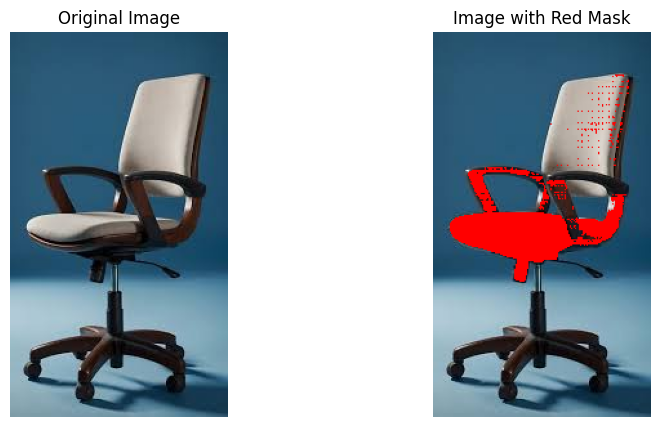

In [ ]:
# Step 7: For Google Colab, we use manual inputs instead of command-line arguments
image_path = "/content/images.jpeg"  # Replace with your image path
class_name = "chair"  # Replace with the class you want to segment
output_path = "/content/output/output_red_mask.png"  # Path to save the output

# Segment the object and output the image
segment_object(image_path, class_name, output_path)